In [2]:
# Import phase if every import is here it is to allow you to run this cell and know if you have any issue and not after a few hours of training

import tensorflow
from tensorflow import keras
import os
import numpy as np
import librosa

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt


from keras_preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.layers import Dense, Dropout, Conv1D, Activation, Flatten, MaxPooling1D, BatchNormalization, LSTM, GaussianNoise
from tensorflow.keras.models import Sequential


from src.VoiceModule import VoiceModule
from src.classifiers.KerasClassifier import KerasClassifier
from prepare_data_utils import load_wav, preprare_wav, split_sample


In [3]:
# print environment
folder_path = "../../data/keywords"
for l in os.listdir(folder_path):
    print(l)

down
tree
_background_noise_
go
house
validation_list.txt
eight
up
bed
two
dog
no
bird
five
marvin
seven
four
visual
happy
nine
data_speech_commands_v0.02.tar.gz
off
yes
forward
follow
README.md
cat
three
on
right
backward
testing_list.txt
sheila
wow
.DS_Store
stop
one
zero
six
learn
LICENSE
left


In [4]:
# Transform data method

def mfcc(buffer, samplerate, dim):
    a = librosa.feature.mfcc(y=buffer, sr=samplerate, n_mfcc=dim)
    a = np.transpose(a)
    return a


In [5]:
# Create callback to later draw some graphs

class PerformanceLogger(Callback):
    def __init__(self):
        # List of tuple (loss, accuracy)
        self.training = []
        self.testing = []
    def on_epoch_end(self, epoch, logs=None):
        self.training.append((logs["loss"], logs["acc"]))
        self.testing.append((logs["val_loss"], logs["val_acc"]))

In [57]:
# Create class
class EmotionClassifierCnn(KerasClassifier):
    def __init__(self, file_path=None):
        super().__init__(file_path)

    def predict(self, x):
        x = np.expand_dims(np.array([x]), axis=2)
        return self._model.predict(x)

    def build(self):
        model = Sequential()
        model.add(GaussianNoise(0.2))
        model.add(BatchNormalization())
        model.add(Conv1D(128, 3, input_shape=(50, 13), padding='same'))
        model.add(Activation('relu'))
        model.add(MaxPooling1D(pool_size=2))
        model.add(Conv1D(64, 3, input_shape=(50, 13), padding='same'))
        model.add(Activation('relu'))
        model.add(MaxPooling1D(pool_size=2))
        model.add(Conv1D(64, 3, input_shape=(50, 13), padding='same'))
        model.add(Activation('relu'))
        model.add(MaxPooling1D(pool_size=2))
        model.add(Dropout(0.4))
        model.add(Flatten())
        model.add(BatchNormalization())
        model.add(Dense(64))
        model.add(Dense(10))
        model.add(Activation('softmax'))
        model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
        self._model = model
        
    def train(self, X, Y, batch_size=32, epoch=720, validation_data=None, callbacks=[]):
        self._model.fit(X, Y, batch_size=batch_size, epochs=epoch, validation_data=validation_data, callbacks=callbacks)

    def transform(self, x, samplerate):
        to_process = mfcc(x, samplerate, 13)
        to_process = pad_sequences([to_process], maxlen=50, padding='post')[0]
        return to_process


In [58]:
#Instanciate model
digit_list = ["zero", "one", "two", "three", "four", "five", "six", "seven", "eight", "nine"]
dimension_mfcc = 13
samplerate = 16000
nb_break=None
sample_duration=1
step=1

logger = PerformanceLogger()

cls = EmotionClassifierCnn()
vm = VoiceModule("digit", digit_list, cls)

In [19]:
# Prepare data for training
data = {f: load_wav(f"{folder_path}/{f}", nb_break) for f in digit_list}
X, Y = preprare_wav(data, vm, sample_duration, step)
print("Done", X.shape)
print(X[0])

Doing zero
Doing one
Doing two
Doing three
Doing four
Doing five
Doing six
Doing seven
Doing eight
Doing nine
Done (35628, 50, 13)
[[-628    0    0    0    0    0    0    0    0    0    0    0    0]
 [-628    0    0    0    0    0    0    0    0    0    0    0    0]
 [-628    0    0    0    0    0    0    0    0    0    0    0    0]
 [-628    0    0    0    0    0    0    0    0    0    0    0    0]
 [-628    0    0    0    0    0    0    0    0    0    0    0    0]
 [-628    0    0    0    0    0    0    0    0    0    0    0    0]
 [-628    0    0    0    0    0    0    0    0    0    0    0    0]
 [-628    0    0    0    0    0    0    0    0    0    0    0    0]
 [-628    0    0    0    0    0    0    0    0    0    0    0    0]
 [-628    0    0    0    0    0    0    0    0    0    0    0    0]
 [-628    0    0    0    0    0    0    0    0    0    0    0    0]
 [-628    0    0    0    0    0    0    0    0    0    0    0    0]
 [-628    0    0    0    0    0    0    0    0    0  

In [22]:
X_file = f"x_{'_'.join(digit_list)}-{vm._name}.npy"
Y_file = f"y_{'_'.join(digit_list)}.npy"

In [23]:
# Saving the prepared input data 
np.save(f"x_{'_'.join(digit_list)}-{vm._name}.npy", X)
np.save(f"y_{'_'.join(digit_list)}.npy", Y)


In [24]:
# Load data for training
X, Y = np.load(X_file), np.load(Y_file)


In [32]:
"""train_size = 80 * len(X) // 100
test_size = 20 * len(X) // 100
#X = np.expand_dims(X, axis=3)
X_train, X_test, = X[:train_size], X[train_size:]
Y_train, Y_test = Y[:train_size], Y[train_size:]"""
X = X.astype('float32')
print(X.shape)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
print(len(X_train), len(X_test))

print(X[0].shape)
print( X.dtype)

(35628, 50, 13)
28502 7126
(50, 13)
float32


In [91]:
vm.model.train(X_train, Y_train, batch_size=512, epoch=1, validation_data=(X_test, Y_test), callbacks=[logger])

Train on 28502 samples, validate on 7126 samples
28502/28502 [==============================] - 3s 109us/sample - loss: 0.0306 - acc: 0.9899 - val_loss: 0.1226 - val_acc: 0.9684


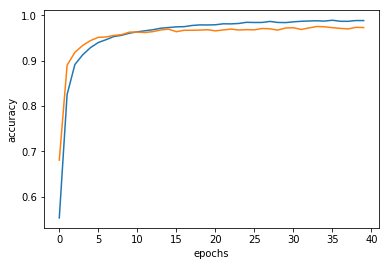

In [62]:

plt.plot(list(range(0, len(logger.training))), list(map(lambda x:x[1], logger.training)), label="training data")
plt.plot(list(range(0, len(logger.testing))), list(map(lambda x:x[1], logger.testing)), label="testing data")
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.show()

In [103]:
# Feature extractor
model = vm._model._model
x = X_train[0]
x = np.array([x])
print(x.shape)
a = vm._model._model.predict(x)
print(a)
print(vm.get_label_from_vector(a), vm.get_label_from_vector(Y_train[0]))


(1, 50, 13)
[[1.5687340e-11 1.1426336e-12 9.9999917e-01 2.7433098e-09 1.3685464e-10
  6.7208073e-14 8.1162534e-07 4.4720819e-10 4.4088999e-10 7.8159483e-16]]
('two', 0.9999988359228915) ('two', 1.0)


In [119]:
extractor = keras.Sequential(
    model.layers[:6]
)
r = extractor.predict(x)
print(r.shape)
print(r[0])

(1, 25, 64)
[[-0.14185035 -0.17482398  0.06754325 ...  0.98260236 -2.601296
  -0.37465987]
 [-0.7184626   0.8385421   0.19931224 ...  0.35096732 -2.0838735
  -0.66924727]
 [-0.57942396  1.2871121  -0.55136746 ... -0.67350966 -1.1483185
   0.3993897 ]
 ...
 [-0.45835727 -0.99142325 -0.337171   ... -0.05280752 -0.3975145
  -0.16613738]
 [-0.476747   -0.95152557 -0.3963178  ...  0.0085771  -0.50116354
  -0.20196696]
 [-0.2219297  -0.6506959  -0.4123219  ... -0.1837841  -0.29274908
  -0.18811883]]
